# U-NET for Diffusion Models

## 卷积与池化

下面展示卷积和池化的示例，以下图为例。

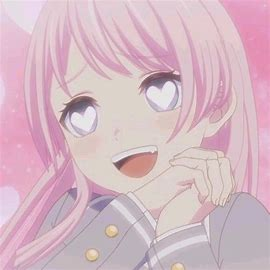

Mode: valid, Output shape: torch.Size([1, 3, 254, 254])
Mode: same, Output shape: torch.Size([1, 3, 256, 256])
Mode: full, Output shape: torch.Size([1, 3, 258, 258])


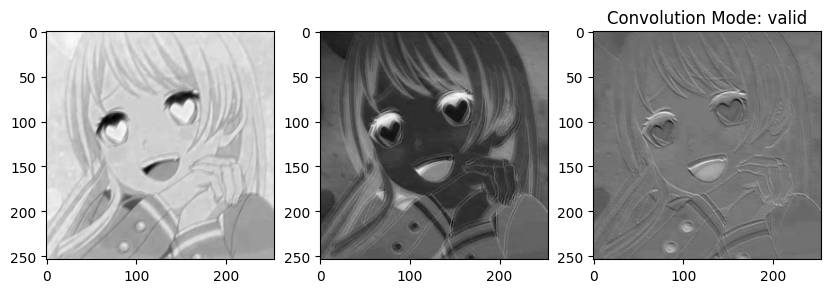

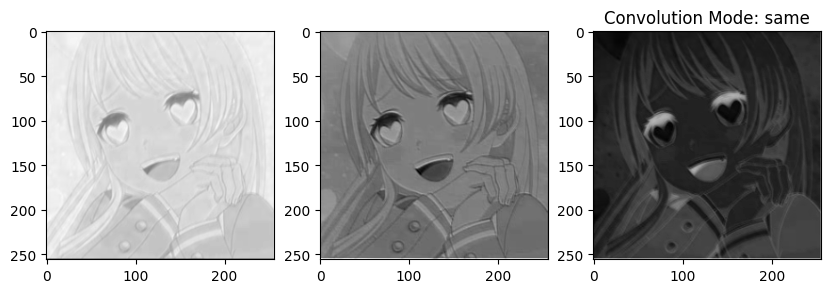

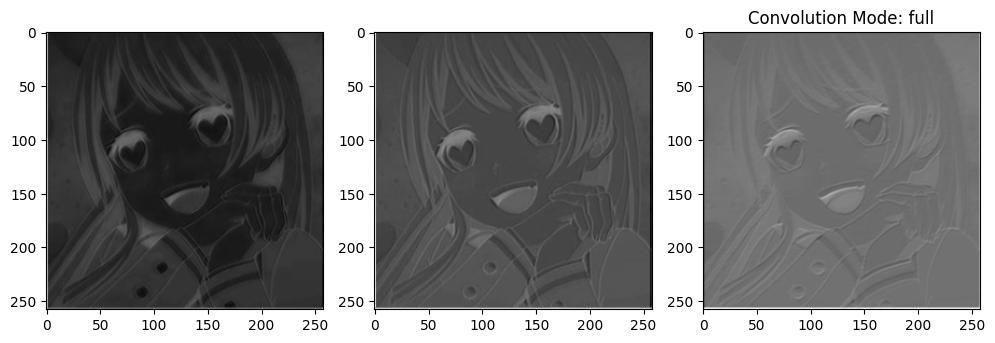

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def get_padding(mode, kernel_size):
    if mode == 'valid':
        return 0
    elif mode == 'same':
        return (kernel_size - 1) // 2
    elif mode == 'full':
        return kernel_size - 1
    else:
        raise ValueError("Invalid mode. Choose from 'valid', 'same', 'full'.")


def perform_convolution(image, kernel_size, mode):
    padding = get_padding(mode, kernel_size)
    conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=kernel_size, padding=padding)
    output = conv(image)
    return output

img_path = 'chihaya.jpg'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image = transform(image).unsqueeze(0)

max_pool = nn.MaxPool2d(2, 2)
avg_pool = nn.AvgPool2d(2, 2)
# 定义卷积核大小
kernel_size = 3

# 三种卷积模式
modes = ['valid', 'same', 'full']

# 进行卷积操作
for mode in modes:
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    output = perform_convolution(image, kernel_size, mode)
    print(f"Mode: {mode}, Output shape: {output.shape}")

    # 可视化特征图（取第一个通道）
    for i in range(3):
        axes[i].imshow(output[0, i].detach().numpy(), cmap='gray')
        plt.title(f"Convolution Mode: {mode}")
        
plt.tight_layout()
plt.show()
    

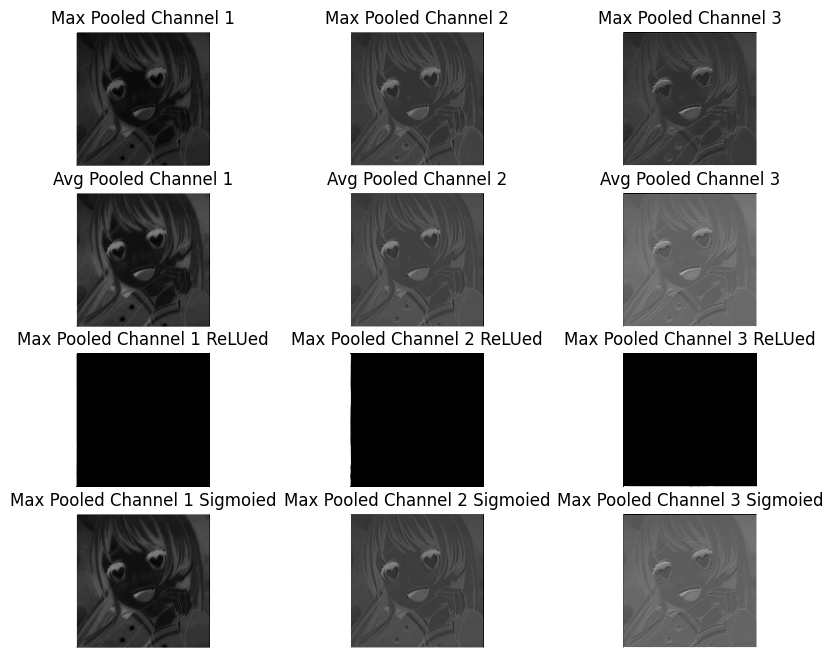

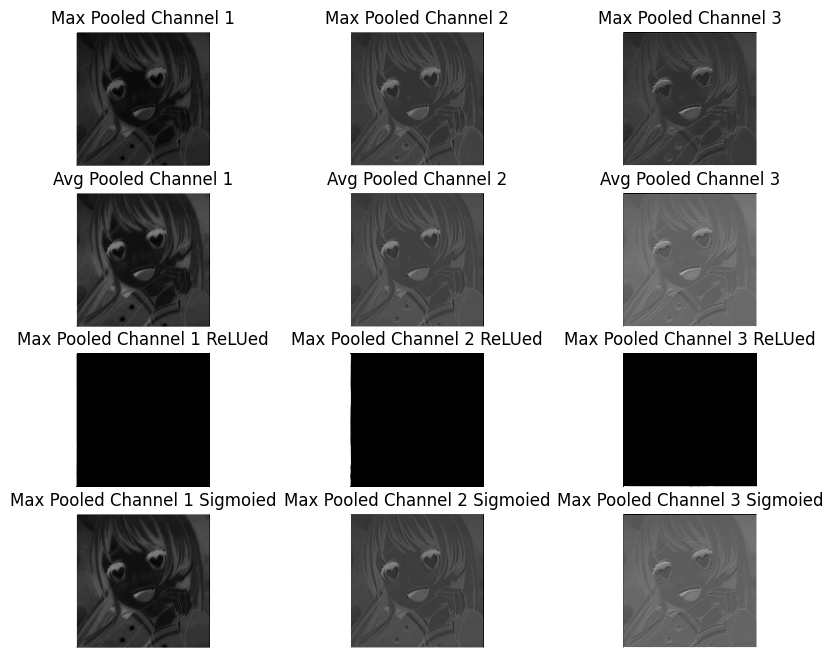

In [3]:
ReLU = nn.ReLU()
Sigmoid = nn.Sigmoid()
for pool in [max_pool, avg_pool]:
    fig, axes = plt.subplots(4, 3, figsize=(10, 8))
    for i in range(3):
        max_pooled = max_pool(output[:, i:i+1, :, :])
        axes[0, i].imshow(max_pooled[0, 0].detach().numpy(), cmap='gray')
        axes[0, i].set_title(f"Max Pooled Channel {i + 1}")
        axes[0, i].axis('off')

            # 平均池化
        avg_pooled = avg_pool(output[:, i:i+1, :, :])
        axes[1, i].imshow(avg_pooled[0, 0].detach().numpy(), cmap='gray')
        axes[1, i].set_title(f"Avg Pooled Channel {i + 1}")
        axes[1, i].axis('off')
        
        max_pooled_relu = ReLU(avg_pooled)
        axes[2, i].imshow(max_pooled_relu[0, 0].detach().numpy(), cmap='gray')
        axes[2, i].set_title(f"Max Pooled Channel {i + 1} ReLUed")
        axes[2, i].axis('off')

        max_pooled_sigm = Sigmoid(avg_pooled)
        axes[3, i].imshow(max_pooled_sigm[0, 0].detach().numpy(), cmap='gray')
        axes[3, i].set_title(f"Max Pooled Channel {i + 1} Sigmoied")
        axes[3, i].axis('off')


## U-NET 的实现

U-NET 由数个编码器和解码器构成。

其中，编码器需要接受上一层的信息，并进行两次卷积操作，接着进行最大池化，并传递给下一层。

解码器接受上一层的信息，依然是进行两次卷积操作，接着进行上采样，并传给下一层。

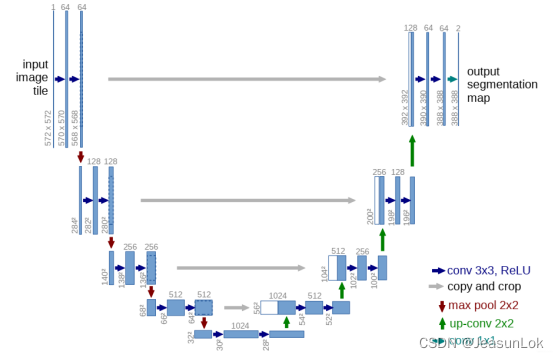

先来实现卷积块：

In [4]:
class DoubleConv(nn.Module):
    # 模型架构
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # 卷积 -> 批归一化 -> ReLU x2
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    # 前向传播
    def forward(self, x):
        return self.double_conv(x)
    

接着融合下采样和卷积层，实现编码器：

In [5]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool_conv = nn.Sequential(
            # 最大池化 -> 两次卷积
            nn.MaxPool2d(2),
            DoubleConv(in_channels=in_channels, out_channels=out_channels)
        )
    def forward(self, x):
        return self.max_pool_conv(x)

接下来融合上采样和卷积层，以及跳跃连接，实现解码器：

> 补充说明：`tensor.size()` 返回一个四元数组：`batch_size, channels, height, width`

In [6]:
import torch.nn.functional as F
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # self.up = nn.ConvTranspose2d(in_channels=in_channels//2, out_channels=out_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels=in_channels, out_channels=out_channels)
    def forward(self, x1, x2):
        # x1 表示上一层的输入，x2 表示跳跃连接的输入
        x1 = self.up(x1)
        # 接下来计算两张量之间的形状差异，以此进行填充
        diffX = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffY = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2], mode='reflect') # 使得不论奇偶，和始终为 diff
        x = torch.cat([x2, x1], dim=1) # 在 channels 维度上进行拼接
        return self.conv(x)

接下来完成输出层：进行两次 1*1 卷积：

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
 
    def forward(self, x):
        return self.conv(x)

U-Net 整体网络编码：

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.n_channels = n_channels

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DownSample(64, 128)
        self.down2 = DownSample(128, 256)
        self.down3 = DownSample(256, 512)
        self.down4 = DownSample(512, 512)
        self.up1 = UpSample(1024, 256)
        self.up2 = UpSample(512, 128)
        self.up3 = UpSample(256, 64)
        self.up4 = UpSample(128, 64)

        # 输出通道数和输入通道数相同 —— 预测噪声
        self.outc = OutConv(64, n_channels) 

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

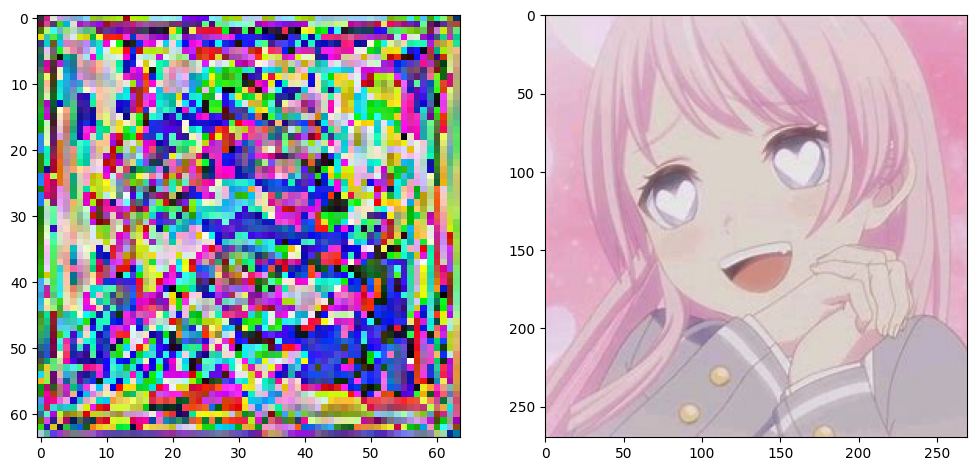

In [9]:
Net = UNet(3)
x = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
x = transform(x).unsqueeze(0)
output = Net(x)

output = output.squeeze(0)

if output.is_cuda:
    output = output.cpu()

from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
to_pil = ToPILImage()
image = to_pil(output)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
origin = Image.open(img_path)
plt.imshow(origin)

plt.show()

## 关于转置卷积和双线性插值的深入研究

在代码中可以采用下列两种方法进行上采样，先介绍转置卷积：转置卷积会根据传入参数改变张量的通道数，同时也会改变张量的宽 $W$ 和高 $H$：
$$H_{out}=(H_{in}-1)\times stride - 2\times padding + dilation\times(kernel\_size - 1)+ output\_padding + 1$$
$$W_{out}=(W_{in}-1)\times stride - 2\times padding + dilation\times(kernel\_size - 1)+ output\_padding + 1$$
一般情况下，若令 `kernel_size=2, stride=2, dilation=1` 其余为0，则：
$$H_{out}=(H_{in}-1)\times 2$$
$$W_{out}=(W_{in}-1)\times 2$$
__通道数按规定变化，图像宽高翻倍__

In [38]:
import torch
v = torch.tensor([[[[1, 2, 3.], [1, 2, 3.], [1, 2, 3.]], [[1, 2, 3.], [1, 2, 3.], [1, 2, 3.]], [[1, 2, 3.], [1, 2, 3.], [1, 2, 3.]], [[1, 2, 3.], [1, 2, 3.], [1, 2, 3.]]]])
# v.size() = [1, 4, 3, 3]
def ConvT(in_ch, out_ch, t):
    convt = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    return convt(t)

w = ConvT(4, 6, v)
w.size()

torch.Size([1, 6, 6, 6])

采用双线性插值，并设定缩放因子为 2 进行上采样：

In [48]:
BiLinear = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
u = BiLinear(v)
u.size()

torch.Size([1, 4, 6, 6])

上面的例子说明，双线性插值不会改变通道数。

接下来我们回顾一下实现 U-Net 时的 `UpSample` 类中的构造函数：为什么使用反卷积就会报错？

In [45]:
a = torch.randn((1, 512, 3, 3))
b = ConvT(512, 256, a)
c = BiLinear(a)
d = ConvT(512, 256//2, a)
print('转置卷积：', b.size())
print('双线性插值：', c.size())
d.size()

转置卷积： torch.Size([1, 256, 6, 6])
双线性插值： torch.Size([1, 512, 6, 6])


torch.Size([1, 128, 6, 6])

如果我们在上采样部分使用反卷积（转置卷积）操作，后面就无需再进行一次卷积以改变通道数。并且，使用转置卷积可以使我们更新上采样的参数。然而，与双线性插值相比，反卷积的计算量要大得多。